In [2]:
#!pip install tensorflow~=2.6.0
#!pip install keras~=2.6.0
#pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
import os
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import time
from IPython import display
from PIL import Image as PImage
%matplotlib inline

In [3]:
def loadImages(path):
    # return array of images
    imagesList = os.listdir(path)
    loadedImages = []
    for i in imagesList: 
        img =  image.imread(path +'/'+ i)
        loadedImages.append(img)
    return loadedImages


path = "C:/Users/ricky/GANProject/archive/train/"
speciesList = os.listdir(path) #list of strings with path of each species
#because appending is costly since you have to copy whole array create an empty array of size of species to read
trainImages =  np.asarray(loadImages(path+speciesList[8])) #and set each element to data for that species
trainImages = trainImages.astype('float32')
trainImages = trainImages/255

In [25]:
def normalize(layer):
    return tf.divide(tf.subtract(layer,tf.reduce_min(layer) ), tf.subtract(tf.reduce_max(layer),tf.reduce_min(layer)))
#take random noise as input and a starting shape that has dimensions ((7,14,28), (7,14,28), (128, 256, 512)
print(tf.__version__)

def make_generator_model(): 
    model = tf.keras.Sequential() 
    model.add(layers.Dense(28*28*256, use_bias=False, input_shape=(100,))) 
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU()) 
    model.add(layers.Reshape((28, 28, 256))) 
    #assert model.output_shape == (None, 7, 7, 256) 
    # Note: None is the batch size 
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)) 
    #assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 28, 28, 64) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 224, 224, 32) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 

    model.add(layers.Conv2D(3, (5, 5), padding='same', use_bias=False, activation='sigmoid')) 
    #assert model.output_shape == (None, 224, 224, 3)
    #model.add(layers.BatchNormalization(center=True,scale=True, gamma_initializer=tf.constant_initializer(0.5), beta_initializer=tf.constant_initializer(0.5)))
    #normalizes values between 0 and 1

    return model


2.6.0


In [53]:

noise = tf.random.normal([1, 100]) #replace 1 with batch size
generated_image = generator(noise, training=False)

In [ ]:
plt.figure(figsize=(12,12))
print(generated_image[0, :, :, :].shape) #check that image has scaled to correct size
plt.imshow(generated_image[0, :, :, :])#for an RGB image values must be scaled from 0 to 1
plt.show()                             #while greyscale will automatically shift values to be between 0 and 1

In [26]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[224, 224, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))  #shape(56, 56, 32)

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))   #shape(14, 14, 64)

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))  #shape(7, 7, 128)
    
    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))  #shape(7, 7, 256)
    model.add(layers.Dropout(0.3))  #dropout is used to prevent overfitting by setting inputs to 0 at a rate determined by paremeter 
                                   #while training. While have to test how this function affects performance

    model.add(layers.Flatten()) #fits all elements into 1 dimension
    model.add(layers.Dense(1,activation='sigmoid'))  #Creates a densely-connected layer of size 1

    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [6]:
def generate_real_samples(dataset, n_samples):
    # choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

In [7]:
# generate n fake samples with class labels
#def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
#	X = np.random.rand(224 * 224 * 3 * n_samples)
	# reshape into a batch of color images
#	X = X.reshape((n_samples, 224, 224, 3))
	# generate 'fake' class labels (0)
#	y = np.zeros((n_samples, 1))
#	return X, y

#def generate_fake_samples(n_samples):
#	generator = make_generator_model()
#	noise = tf.random.normal([n_samples, 100]) #replace 1 with batch size
#	generated_image = generator(noise, training=False)
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

In [8]:
def train_discriminator(model, dataset, n_iter=40, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
discrim = make_discriminator_model()
train_discriminator(discrim, trainImages)

In [9]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = tf.keras.Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

6
>1, 1/6, d1=0.681, d2=1.375 g=0.594
>1, 2/6, d1=0.581, d2=0.809 g=0.631
>1, 3/6, d1=0.659, d2=0.729 g=0.624
>1, 4/6, d1=0.685, d2=0.713 g=0.548
>1, 5/6, d1=0.666, d2=0.704 g=0.408
>1, 6/6, d1=0.650, d2=0.800 g=0.357
>2, 1/6, d1=0.690, d2=0.707 g=0.326
>2, 2/6, d1=0.661, d2=0.662 g=0.086
>2, 3/6, d1=0.548, d2=0.684 g=0.001
>2, 4/6, d1=0.503, d2=0.676 g=0.000
>2, 5/6, d1=0.608, d2=0.911 g=0.000
>2, 6/6, d1=0.665, d2=0.571 g=0.000
>3, 1/6, d1=0.880, d2=0.577 g=0.001
>3, 2/6, d1=0.591, d2=0.588 g=0.000
>3, 3/6, d1=0.618, d2=0.602 g=0.000
>3, 4/6, d1=0.460, d2=0.600 g=0.000
>3, 5/6, d1=0.291, d2=0.555 g=0.000
>3, 6/6, d1=0.276, d2=0.786 g=0.000
>4, 1/6, d1=0.351, d2=0.474 g=0.000
>4, 2/6, d1=1.119, d2=0.469 g=0.000
>4, 3/6, d1=0.575, d2=0.549 g=0.000
>4, 4/6, d1=0.628, d2=0.573 g=0.000
>4, 5/6, d1=0.296, d2=0.550 g=0.000
>4, 6/6, d1=0.492, d2=0.526 g=0.000
>5, 1/6, d1=0.284, d2=0.644 g=0.000
>5, 2/6, d1=0.274, d2=0.394 g=0.000
>5, 3/6, d1=0.752, d2=0.413 g=0.000
>5, 4/6, d1=0.361, d2=0.60

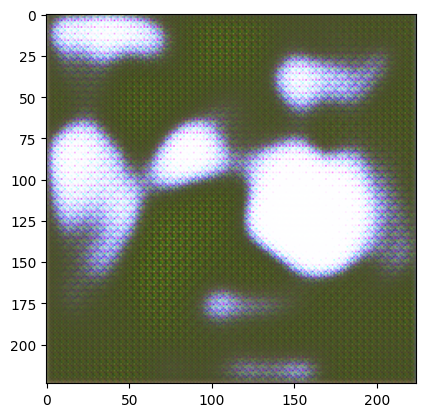

In [30]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=20):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	print(bat_per_epo)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			plt.imshow(X_fake[0])
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))


# size of the latent space
latent_dim = 100
# create the discriminator
d_model = make_discriminator_model()
# create the generator
g_model = make_generator_model()
# create the gan
gan_model = define_gan(g_model, d_model)
# train model
train(g_model, d_model, gan_model, trainImages, latent_dim)